**кластеризатор КНП**


Евгений Борисов esborisov@sevsu.ru


---

In [1]:
import numpy as np
from numpy import random as rng
import numpy.ma as ma
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

np.set_printoptions(precision=2)

## генерируем данные

In [2]:
# from sklearn.datasets import make_blobs

# X,_ = make_blobs(n_samples=256,centers=5,cluster_std=rng.uniform(size=5)+.7 )
# display( X.shape )

# fig, ax = plt.subplots(figsize=(6,5))
# ax.scatter( x=X[:,0], y=X[:,1], s=2, alpha=0.5 )
# ax.grid()
# plt.show()

----

(256, 2)

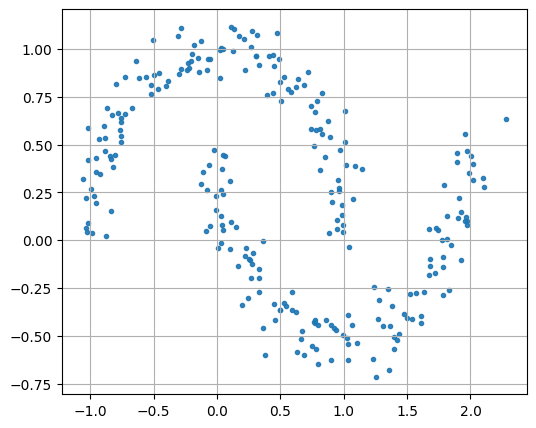

In [3]:
from sklearn.datasets import make_moons

X, _ = make_moons(n_samples=256, noise=.09)
display( X.shape )

fig, ax = plt.subplots(figsize=(6,5))
ax.scatter( x=X[:,0], y=X[:,1], marker='.', alpha=.9 )
ax.grid()
plt.show()

## кластеризатор КНП

In [10]:
from sklearn.metrics.pairwise import euclidean_distances as metric

In [11]:
class KNPClustering:
    
    def __init__(self,metric=metric):
        self._metric = metric
        
    def fit(self,X): return self
    
    def predict(self,X,n_split=1): 
        assert n_split>0
        D,edges = self._build_graph(X)
        edges = self._split_graph(D,edges,n_split)
        return edges
        
    def _build_graph(self,X):        
        D,edges = self._init_graph(X)
        for _ in tqdm(range(len(X)-2)):
            edges = self._add_node(D,edges)
        return D,edges
        
    def _init_graph(self,X):
        D = metric(X) # матрица расстояний
        # маскируем верхнюю часть матрицы расстояний, включая главную диагональ
        D_ = ma.masked_array( D, mask=np.triu(np.ones(D.shape,dtype=np.uint8)) ) 
        p_idx = ma.where( D_ == D_.min() ) # ищем две наиболее близкие точки
        return D, [ [ p_idx[0][0], p_idx[1][0] ], ] # соединяем их ребром    
        
    @staticmethod
    def _add_node(D,edges):
        p_used = sorted(set(sum(edges,[]))) # список связанных точек
        p_free = list(set(range(D.shape[0])).difference(p_used)) # список несвязанных точек
        # маскируем главную диагональ ...
        mask = np.eye(D.shape[0],dtype=np.uint8)
        # ... и пары из уже связанных или ещё несвязанных точек
        mask = mask[p_used,:][:,p_free]
        # ищем ближайшую к графу несвязанную точку 
        D_ = ma.masked_array( D[p_used,:][:,p_free], mask=mask )
        p_idx = ma.where( D_ == D_.min() )
        # добавляем новое ребро к графу
        return edges + [ [ p_used[p_idx[0][0]], p_free[p_idx[1][0]] ] ]

    @staticmethod
    def _split_graph(D,edges,n_split=1):
        # ищём индексы n_split самых длинных рёбер
        edge_max_idx = np.argsort( [ D[*e] for e in edges ] )[-n_split:] 
        # выкидываем n_split самых длинных рёбер 
        return [ edges[n] for n in range(len(edges)) if not (n in edge_max_idx) ]

In [12]:
model = KNPClustering().fit(X)
edges = model.predict(X,n_split=2)

  0%|          | 0/254 [00:00<?, ?it/s]

## конвертируем граф в метки кластеров

In [7]:
from scipy.sparse import csr_matrix

class GraphConverter:

    def __init__(self):
        self._C = csr_matrix([])        

    def transform(self,edges): 
        self._connectivity_matrix(edges)
        return self._nodes_to_labels(self._edges_to_nodes(edges))

    def _connectivity_matrix(self,edges):
        rows = [ n0 for n0,_ in edges ]
        cols = [ n1 for _,n1 in edges ]
        s = max(rows+cols)+1
        data = np.ones(len(edges),dtype=np.uint8)
        # несимметричная матрица смежности
        self._C = csr_matrix((data,(rows,cols)),shape=(s,s) )
        assert len(edges) == self._C.nnz
        return self 
        
    def _edges_to_nodes(self,edges):
        clusters = []
        nodes = [ n0 for n0,_ in edges ]
        assert max(nodes)<self._C.shape[0]
        while len(nodes)>0:
            n0 = nodes[0]
            cluster = self._search_connected_nodes(n0)+[n0]
            clusters.append( cluster )
            nodes = [ n0 for n0 in nodes if not(n0 in cluster) ]    
        return clusters
    
    def _search_connected_nodes(self,n0):
        _,nn1 = self._C[n0,:].nonzero() # ищем узлы связанные с n0
        nn1 = list(nn1)
        # рекуррентно повторяем для всех найденных узлов
        return nn1 +[ n2 for n1 in nn1 for n2 in self._search_connected_nodes(n1) ]
        
    @staticmethod
    def _nodes_to_labels(clusters):
        max_idx = max(sum(clusters,[]))
        labels = np.zeros(max_idx+1,dtype=int)
        for n,cc in enumerate(clusters): labels[cc] = n+1
        return labels

In [8]:
labels = GraphConverter().transform(edges)

## рисуем результат

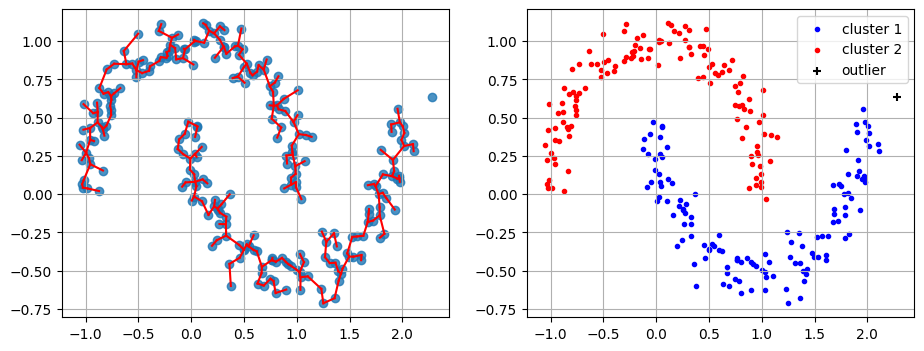

In [9]:
color_list = 'mbrgc'*50 
fig,ax = plt.subplots(ncols=2,figsize=(11,4))

ax[0].scatter( x=X[:,0], y=X[:,1], marker='o', alpha=0.8 )
for n1,n2 in edges: ax[0].plot([ X[n1,0],X[n2,0] ], [ X[n1,1],X[n2,1] ], c='r' )
ax[0].grid()

for c in range(1,labels.max()+1):
    ax[1].scatter( x=X[labels==c,0], y=X[labels==c,1], marker='.', c=color_list[c], label=f'cluster {c}' )
if 0 in labels:
    ax[1].scatter( x=X[labels==0,0], y=X[labels==0,1], marker='+', c='k', label='outlier' )

ax[1].legend()   
ax[1].grid()